# Load data

In [50]:
# Import những thứ cơ bản ở trên cùng
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt

__target_size = (224,224)
__directory = r'/content/drive/MyDrive/ripe_fruit/data'

from imutils import paths
image_path = list(paths.list_images(__directory))


import random
random.shuffle(image_path)

import os
labels = [p.split(os.path.sep)[-2] for p in image_path]

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import imagenet_utils
list_image = []
for (i, imagePath) in enumerate(image_path):
    print('->', end='')
    image = load_img(imagePath, target_size=__target_size)
    image = img_to_array(image)

    image = np.expand_dims(image, 0)
    image = imagenet_utils.preprocess_input(image)
    
    list_image.append(image)
    
list_image = np.vstack(list_image)

print('list_image.shape = ', list_image.shape)
print('labels = ', labels)


# KHÔNG CẦN One-hot encoding nếu cho vào sklearn model
# from sklearn.preprocessing import LabelBinarizer
# lb = LabelBinarizer()
# labels = lb.fit_transform(labels)
# print(labels)


->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->list_image.shape =  (308, 224, 224, 3)
labels =  [1 0 2 0 2 1 2 1 2 0 2 1 2 1 2 2 0 0 2 2 1 2 0 1 2 2 0 0 0 2 0 2 2 1 0 1 1
 2 1 1 0 2 1 1 2 0 2 2 2 0 2 1 2 0 2 1 1 0 1 2 1 0 0 0 1 1 1 0 0 1 2 0 0 2
 1 1 1 0 2 1 1 0 0 2 1 2 1 0 0 0 2 0 2 1 1 1 1 1 1 1 1 1 2 0 2 2 1 0 0 2 2
 2 2 0 0 2 1 0 0 1 0 2 2 2 1 1 2 2 2 0 1 1 2 0 2 2 1 1 0 0 0 1 0 2 0 0 0 1
 0 1 1 2 2 1 2 2 1 0 2 2 0 2 1 0 0 

In [51]:

from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(list_image/255.0, labels, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print('X_train.shape = ', X_train.shape)
print('X_val.shape =', X_val.shape)
print('X_test.shape =', X_test.shape)


from keras.utils import np_utils
Y_train = np_utils.to_categorical(y_train)
Y_val = np_utils.to_categorical(y_val)
Y_test = np_utils.to_categorical(y_test)

# cnt = [0,0,0]
# for y in y_train:
#     cnt[y] += 1
# print(cnt)

# cnt = [0,0,0]
# for y in y_val:
#     cnt[y] += 1
# print(cnt)

# cnt = [0,0,0]
# for y in y_test:
#     cnt[y] += 1
# print(cnt)

X_train.shape =  (221, 224, 224, 3)
X_val.shape = (56, 224, 224, 3)
X_test.shape = (31, 224, 224, 3)


# Data aug

In [52]:
img_gen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    # rescale=1./255,    # da scale roi
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

gen1 = img_gen.flow(
    x=X_train,
    y=Y_train,
    batch_size=16,
    shuffle=False,
)

gen2 = img_gen.flow(
    x=X_train,
    y=Y_train,
    batch_size=16,
    shuffle=False,
)

# Feature extracting

In [53]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model


pretrained_model = MobileNetV2(
    include_top=False,
    alpha=0.75,
    weights='imagenet',
    input_shape=(224,224,3),
)
pretrained_model.summary()

x = pretrained_model.get_layer('out_relu').output
# x = GlobalAveragePooling2D()(x)
# x = Flatten()(x)

feature_extractor = Model(inputs=pretrained_model.input,
                          outputs = x)
fmap_train1 = feature_extractor.predict(gen1) #, steps = 20)
fmap_train2 = feature_extractor.predict(gen2)
fmap_val = feature_extractor.predict(X_val)

fmap_train = np.concatenate((fmap_train1, fmap_train2))
Y_train = np.concatenate((Y_train, Y_train))

Model: "mobilenetv2_0.75_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 24  648         ['input_22[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 24  96          ['Conv1[0][0]']                  
                                )                                              

In [54]:
fmap_train1.shape
#(221, 7, 7, 512)
fmap_train2.shape
#(221, 7, 7, 512)


(221, 7, 7, 1280)

# Training classifier

In [55]:
mlp_model = keras.models.Sequential([
    keras.layers.Input(shape=[7,7,1280]),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(16, activation="relu"),  # tang so luong unit o hai layer nay chua thay tang test acc
    # keras.layers.Dense(8, activation='relu'), # them so layer cung khong duoc
    keras.layers.Dense(3, activation="softmax")
])

mlp_model.compile(loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    metrics=["accuracy"]
)

mlp_model.summary()

history = mlp_model.fit(
    x=fmap_train, y=Y_train,
    validation_data=(fmap_val, Y_val),
    epochs=50,
    batch_size=16,
    # steps_per_epoch=30
)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 62720)             0         
                                                                 
 dense_34 (Dense)            (None, 32)                2007072   
                                                                 
 dense_35 (Dense)            (None, 16)                528       
                                                                 
 dense_36 (Dense)            (None, 3)                 51        
                                                                 
Total params: 2,007,651
Trainable params: 2,007,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
28/28 [==============================] - 1s 17ms/step - loss: 1.2042 - accuracy: 0.3643 - val_loss: 1.0552 - val_accuracy: 0.4464
Epoch 2/50
28/28 [================

In [56]:
print(fmap_train.shape)
print(Y_train.shape)

print(fmap_val.shape)
print(Y_val.shape)

(442, 7, 7, 1280)
(442, 3)
(56, 7, 7, 1280)
(56, 3)


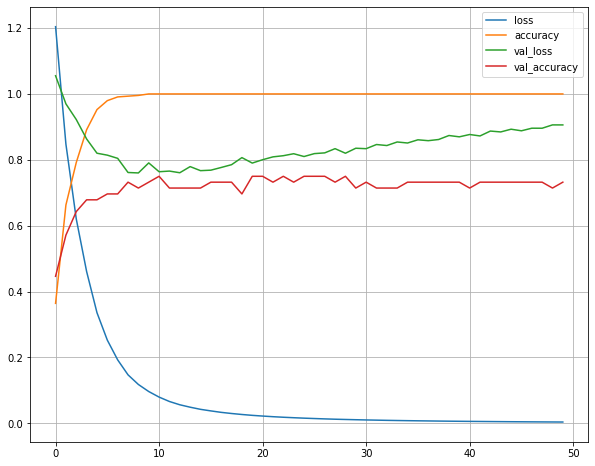

In [57]:
def plot_history(x):
    import pandas as pd
    import matplotlib.pyplot as plt
    pd.DataFrame(x.history).plot(figsize=(10,8))
    plt.grid(True)
    # plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
    plt.show()  
plot_history(history)

In [58]:
fmap_test = pretrained_model.predict(X_test)
results = mlp_model.evaluate(fmap_test, Y_test)
print("test loss: ", results[0],  "test acc: ", results[1])

1/1 [==============================] - 0s 29ms/step - loss: 0.4681 - accuracy: 0.8710
test loss:  0.4680563509464264 test acc:  0.8709677457809448


In [59]:
mlp_model.save("/content/drive/MyDrive/ripe_fruit/mobilenet-mlp-14-12.h5")
